In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

1. Clean and preprocess the data, handling missing values, encoding categorical data, and normalizing measurements.

From the given [dataset](https://market.oceanprotocol.com/asset/did:op:14312f0acb356539b95138f9e2cd54e9a00aa1f963d74e3e60268a089a196a5e). We first converted the `METAR` data column into a format in which the different datapoints are inferred using the [metpy](https://unidata.github.io/MetPy/latest/api/generated/metpy.io.parse_metar_to_dataframe.html) library. `metar_normalised.csv` is the resultant dataset of this processing

In [ ]:
file_path = 'drive/MyDrive/metar_normalised.csv'
metar_data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset to understand its structure
metar_data.head()

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,wind_gust,visibility,current_wx1,...,skyc4,skylev4,cloudcover,temperature,dewpoint,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks
0,KMIA,25.8,-80.28,3,2014-01-01 00:53:00,40.0,9.0,15.0,16093.44,NaN,...,NaN,NaN,8,23.0,18.0,30.21,0,0,0,AO2 SLP229 T02330183
1,KMIA,25.8,-80.28,3,2014-01-01 01:53:00,40.0,9.0,15.0,16093.44,NaN,...,NaN,NaN,8,23.0,18.0,30.21,0,0,0,AO2 SLP231 T02330183
2,KMIA,25.8,-80.28,3,2014-01-01 02:53:00,50.0,9.0,19.0,16093.44,-RA,...,NaN,NaN,8,23.0,18.0,30.23,61,0,0,AO2 RAB44 SLP236 P0000 60000 T02280178 51013
3,KMIA,25.8,-80.28,3,2014-01-01 03:53:00,70.0,10.0,NaN,16093.44,NaN,...,NaN,NaN,8,23.0,17.0,30.21,0,0,0,AO2 RAE09 SLP229 P0000 T02330172
4,KMIA,25.8,-80.28,3,2014-01-01 04:53:00,70.0,10.0,NaN,16093.44,NaN,...,NaN,NaN,8,24.0,18.0,30.19,0,0,0,AO2 SLP223 T02390178 402500194


In [ ]:
# Checking for missing values in each column
missing_values = metar_data.isnull().sum()
missing_values[missing_values > 0]  # Display columns with missing values and their counts

wind_direction     4193
wind_speed          143
wind_gust         76671
visibility           37
current_wx1       82480
current_wx2       88109
current_wx3       89574
skyc1                49
skylev1            4959
skyc2             22657
skylev2           22657
skyc3             52172
skylev3           52172
skyc4             79486
skylev4           79486
temperature          69
dewpoint             73
altimeter            19
remarks              20
dtype: int64

Now,

1. **Wind Direction, Wind Speed, Visibility, Temperature, Dewpoint, Altimeter:** For these meteorological measurements, we can impute missing values using methods like mean or median imputation, as they are continuous variables.
2. **Wind Gust:** This column has a large number of missing values. If wind gusts are not frequently recorded, we might consider dropping this column as they may not contribute a lot to the analysis. Also note that since this is a continuous variable we can't handle it by considering None as a separate variable - the way we can do it for categorical variables.
3. **Weather Conditions (current_wx1, current_wx2, current_wx3):** These are categorical and have a significant number of missing values. We can encode missing values as a separate category.
4. **Sky Conditions (skyc1, skyc2, skyc3, skyc4):** Similar to weather conditions.
5. **Sky Levels (skylev1, skylev2, skylev3, skylev4):** All of these are continuous variables and although `skylev1` has few missing columns `skylev2/3/4` have a lot of missing values. So we are going to impute skylev1 as mean and drop the other columns.
5. **Remarks:** This column seems to contain additional remarks. We can treat missing values as a separate category or even drop the column for quantitative analysis.

In [ ]:
# Imputing missing values for continuous variables with mean
mean_imputer = SimpleImputer(strategy='mean')
continuous_columns = ['wind_direction', 'wind_speed', 'visibility', 'skylev1', 'cloudcover', 'temperature', 'dewpoint', 'altimeter']
metar_data[continuous_columns] = mean_imputer.fit_transform(metar_data[continuous_columns])

# Dropping a few columns due to large number of missing values
metar_data.drop(columns=['wind_gust', 'skylev2', 'skylev3', 'skylev4'], inplace=True)

# For categorical weather and sky conditions, we treat missing values as a separate category ('None')
categorical_columns = ['current_wx1', 'current_wx2', 'current_wx3', 'skyc1', 'skyc2', 'skyc3', 'skyc4']
metar_data[categorical_columns] = metar_data[categorical_columns].fillna('None')

# Handling missing values in 'remarks' column
metar_data['remarks'] = metar_data['remarks'].fillna('No remarks')

# Check the dataset after imputation and column removal
metar_data.isnull().sum()  # This should show no missing values now


station_id            0
latitude              0
longitude             0
elevation             0
date_time             0
wind_direction        0
wind_speed            0
visibility            0
current_wx1           0
current_wx2           0
current_wx3           0
skyc1                 0
skylev1               0
skyc2                 0
skyc3                 0
skyc4                 0
cloudcover            0
temperature           0
dewpoint              0
altimeter             0
current_wx1_symbol    0
current_wx2_symbol    0
current_wx3_symbol    0
remarks               0
dtype: int64

In [ ]:
metar_data.columns

Index(['station_id', 'latitude', 'longitude', 'elevation', 'date_time',
       'wind_direction', 'wind_speed', 'visibility', 'current_wx1',
       'current_wx2', 'current_wx3', 'skyc1', 'skylev1', 'skyc2', 'skyc3',
       'skyc4', 'cloudcover', 'temperature', 'dewpoint', 'altimeter',
       'current_wx1_symbol', 'current_wx2_symbol', 'current_wx3_symbol',
       'remarks'],
      dtype='object')

In [ ]:
# Applying Min-Max Scaling
scaler = MinMaxScaler()
metar_data[continuous_columns] = scaler.fit_transform(metar_data[continuous_columns])

# Displaying the dataset to check the normalization
metar_data[continuous_columns].head()

,wind_direction,wind_speed,visibility,skylev1,cloudcover,temperature,dewpoint,altimeter
0,0.111111,0.209302,1.0,0.072254,0.8,0.575758,0.722222,0.769231
1,0.111111,0.209302,1.0,0.066474,0.8,0.575758,0.722222,0.769231
2,0.138889,0.209302,1.0,0.072254,0.8,0.575758,0.722222,0.784615
3,0.194444,0.232558,1.0,0.080925,0.8,0.575758,0.694444,0.769231
4,0.194444,0.232558,1.0,0.080925,0.8,0.606061,0.722222,0.753846


In [ ]:
metar_data.columns

Index(['station_id', 'latitude', 'longitude', 'elevation', 'date_time',
       'wind_direction', 'wind_speed', 'visibility', 'current_wx1',
       'current_wx2', 'current_wx3', 'skyc1', 'skylev1', 'skyc2', 'skyc3',
       'skyc4', 'cloudcover', 'temperature', 'dewpoint', 'altimeter',
       'current_wx1_symbol', 'current_wx2_symbol', 'current_wx3_symbol',
       'remarks'],
      dtype='object')

In [ ]:
metar_data.head()

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,visibility,current_wx1,current_wx2,...,skyc3,skyc4,cloudcover,temperature,dewpoint,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks
0,KMIA,25.8,-80.28,3,2014-01-01 00:53:00,0.111111,0.209302,1.0,None,None,...,None,None,0.8,0.575758,0.722222,0.769231,0,0,0,AO2 SLP229 T02330183
1,KMIA,25.8,-80.28,3,2014-01-01 01:53:00,0.111111,0.209302,1.0,None,None,...,None,None,0.8,0.575758,0.722222,0.769231,0,0,0,AO2 SLP231 T02330183
2,KMIA,25.8,-80.28,3,2014-01-01 02:53:00,0.138889,0.209302,1.0,-RA,None,...,None,None,0.8,0.575758,0.722222,0.784615,61,0,0,AO2 RAB44 SLP236 P0000 60000 T02280178 51013
3,KMIA,25.8,-80.28,3,2014-01-01 03:53:00,0.194444,0.232558,1.0,None,None,...,None,None,0.8,0.575758,0.694444,0.769231,0,0,0,AO2 RAE09 SLP229 P0000 T02330172
4,KMIA,25.8,-80.28,3,2014-01-01 04:53:00,0.194444,0.232558,1.0,None,None,...,None,None,0.8,0.606061,0.722222,0.753846,0,0,0,AO2 SLP223 T02390178 402500194


In [ ]:
# drop some location specific columns since we are only dealing with one location
metar_data.drop(columns=['station_id', 'latitude', 'longitude', 'elevation'], inplace=True)

Conduct feature engineering to extract additional useful information from the data (e.g., time-based features, rolling averages).

1. Extract time-based features from the date_time column.
2. Calculate rolling averages for selected measurements. We'll choose a window size that makes sense for this dataset, such as 24 hours for daily trends.

In [ ]:
# Convert date_time from string to datetime
metar_data['date_time'] = pd.to_datetime(metar_data['date_time'])

# Extracting time-based features
metar_data['month'] = metar_data['date_time'].dt.month
metar_data['day_of_week'] = metar_data['date_time'].dt.dayofweek
metar_data['hour'] = metar_data['date_time'].dt.hour

In [ ]:
# Applying a 24-hour rolling average
for measurement in continuous_columns:
    metar_data[f'{measurement}_rolling_avg'] = metar_data[measurement].rolling(window=24, min_periods=1).mean()

# Displaying the dataset with the new features
metar_data[['date_time', 'month', 'day_of_week', 'hour', 'wind_direction_rolling_avg', 'wind_speed_rolling_avg', 'cloudcover_rolling_avg', 'visibility_rolling_avg', 'skylev1_rolling_avg', 'temperature_rolling_avg', 'dewpoint_rolling_avg', 'altimeter_rolling_avg']].head()

,date_time,month,day_of_week,hour,wind_direction_rolling_avg,wind_speed_rolling_avg,cloudcover_rolling_avg,visibility_rolling_avg,skylev1_rolling_avg,temperature_rolling_avg,dewpoint_rolling_avg,altimeter_rolling_avg
0,2014-01-01 00:53:00,1,2,0,0.111111,0.209302,0.8,1.0,0.072254,0.575758,0.722222,0.769231
1,2014-01-01 01:53:00,1,2,1,0.111111,0.209302,0.8,1.0,0.069364,0.575758,0.722222,0.769231
2,2014-01-01 02:53:00,1,2,2,0.120370,0.209302,0.8,1.0,0.070328,0.575758,0.722222,0.774359
3,2014-01-01 03:53:00,1,2,3,0.138889,0.215116,0.8,1.0,0.072977,0.575758,0.715278,0.773077
4,2014-01-01 04:53:00,1,2,4,0.150000,0.218605,0.8,1.0,0.074566,0.581818,0.716667,0.769231


In [ ]:
metar_data.head()

,date_time,wind_direction,wind_speed,visibility,current_wx1,current_wx2,current_wx3,skyc1,skylev1,skyc2,...,day_of_week,hour,wind_direction_rolling_avg,wind_speed_rolling_avg,visibility_rolling_avg,skylev1_rolling_avg,cloudcover_rolling_avg,temperature_rolling_avg,dewpoint_rolling_avg,altimeter_rolling_avg
0,2014-01-01 00:53:00,0.111111,0.209302,1.0,None,None,None,OVC,0.072254,None,...,2,0,0.111111,0.209302,1.0,0.072254,0.8,0.575758,0.722222,0.769231
1,2014-01-01 01:53:00,0.111111,0.209302,1.0,None,None,None,OVC,0.066474,None,...,2,1,0.111111,0.209302,1.0,0.069364,0.8,0.575758,0.722222,0.769231
2,2014-01-01 02:53:00,0.138889,0.209302,1.0,-RA,None,None,OVC,0.072254,None,...,2,2,0.120370,0.209302,1.0,0.070328,0.8,0.575758,0.722222,0.774359
3,2014-01-01 03:53:00,0.194444,0.232558,1.0,None,None,None,OVC,0.080925,None,...,2,3,0.138889,0.215116,1.0,0.072977,0.8,0.575758,0.715278,0.773077
4,2014-01-01 04:53:00,0.194444,0.232558,1.0,None,None,None,OVC,0.080925,None,...,2,4,0.150000,0.218605,1.0,0.074566,0.8,0.581818,0.716667,0.769231


#### **Distribution of weather parameters**

We can notice a roughly normal distribution for dewpoint, temperature and altimeter datapoints. Whereas for the dewpoint it seems like we have a right skewed distribution and vice-versa for wind_speed.

As for wind speed it seems like we have majority of the normalised datapoints around 1.

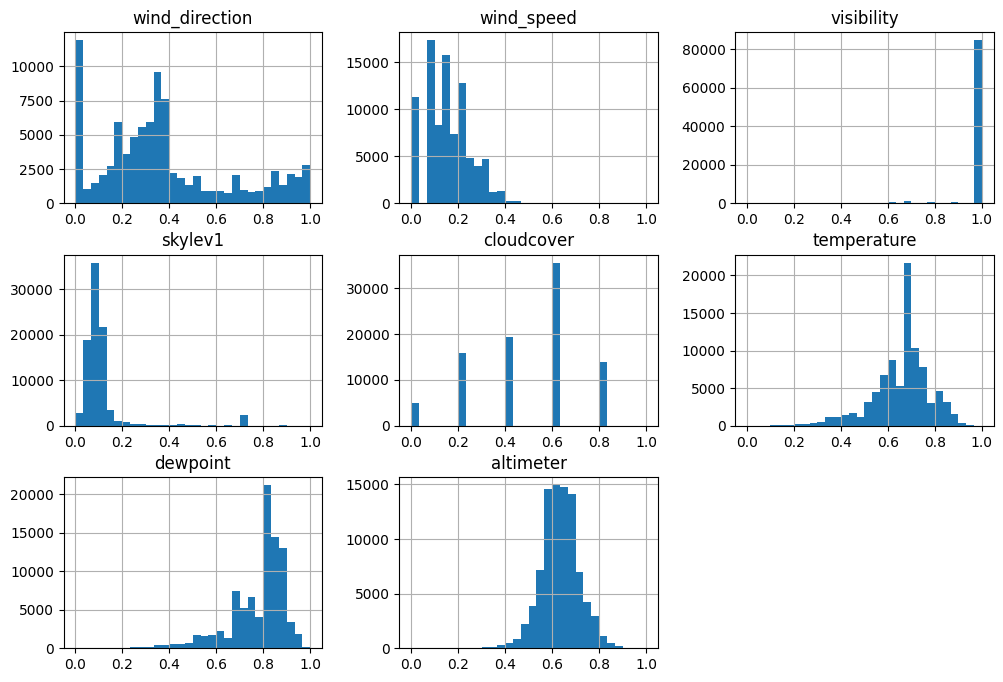

In [ ]:
# Histograms
metar_data[continuous_columns].hist(bins=30, figsize=(12, 8))
plt.show()

#### **Time based analysis when resample by day**

We can notice that when sampled acorss a day only temperature and dewpoint show signs of seasonality. The seasonality in temperature and dewpoint is naturally expected

<ipython-input-287-44f8b85d3883>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_data = metar_data.resample('D').mean()


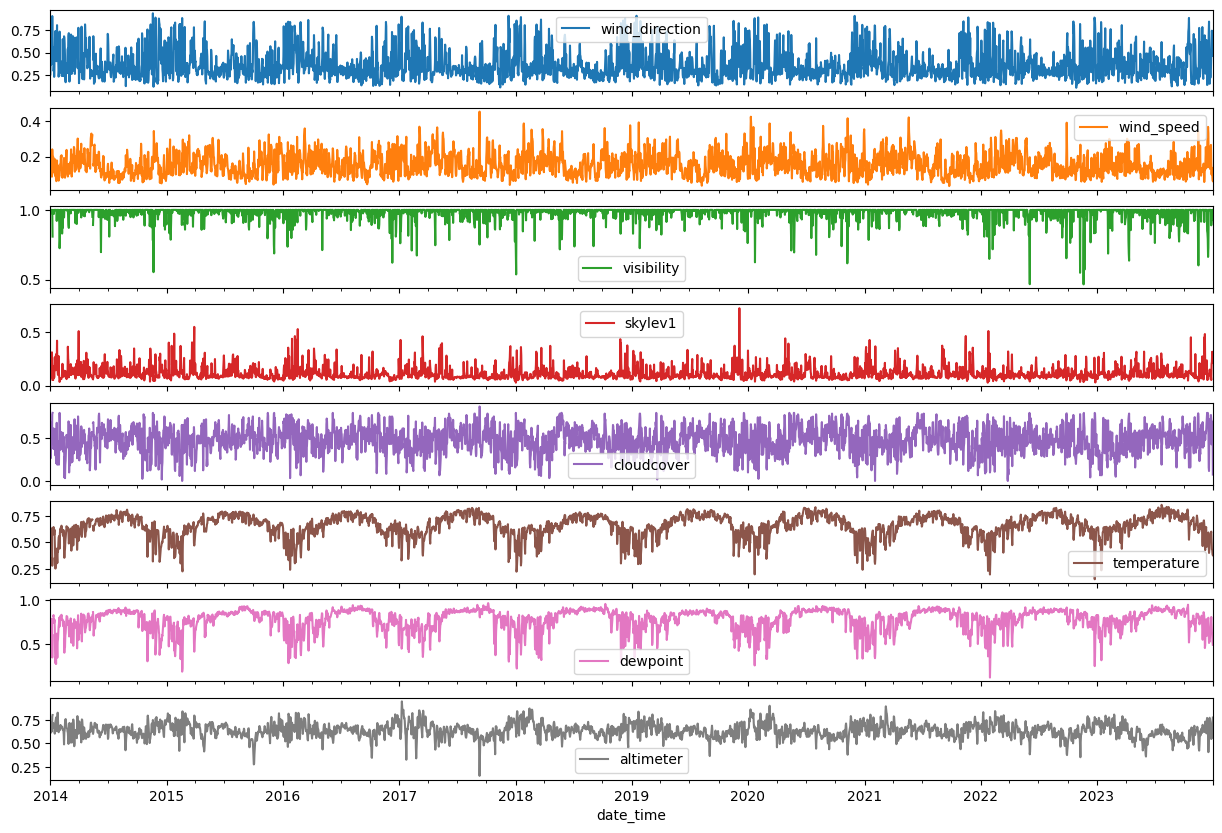

In [ ]:
# Resampling to daily averages for a smoother trend over time
metar_data['date_time'] = pd.to_datetime(metar_data['date_time'])  # Ensure date_time is datetime type
metar_data.set_index('date_time', inplace=True)

daily_data = metar_data.resample('D').mean()

# Plotting trends over time
daily_data[continuous_columns].plot(subplots=True, figsize=(15, 10))
plt.show()

#### **Time based analysis when resample by month**

We can notice that when sampled acorss months, the seasonality in temperature and dewpoint becomes more pronounced. We can also notice some seasonality in the altimeter readings indicating that the atmospheric pressure is typically higher in winters compare to the summers.

<ipython-input-288-0da44ff03c33>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_data = metar_data.resample('M').mean()


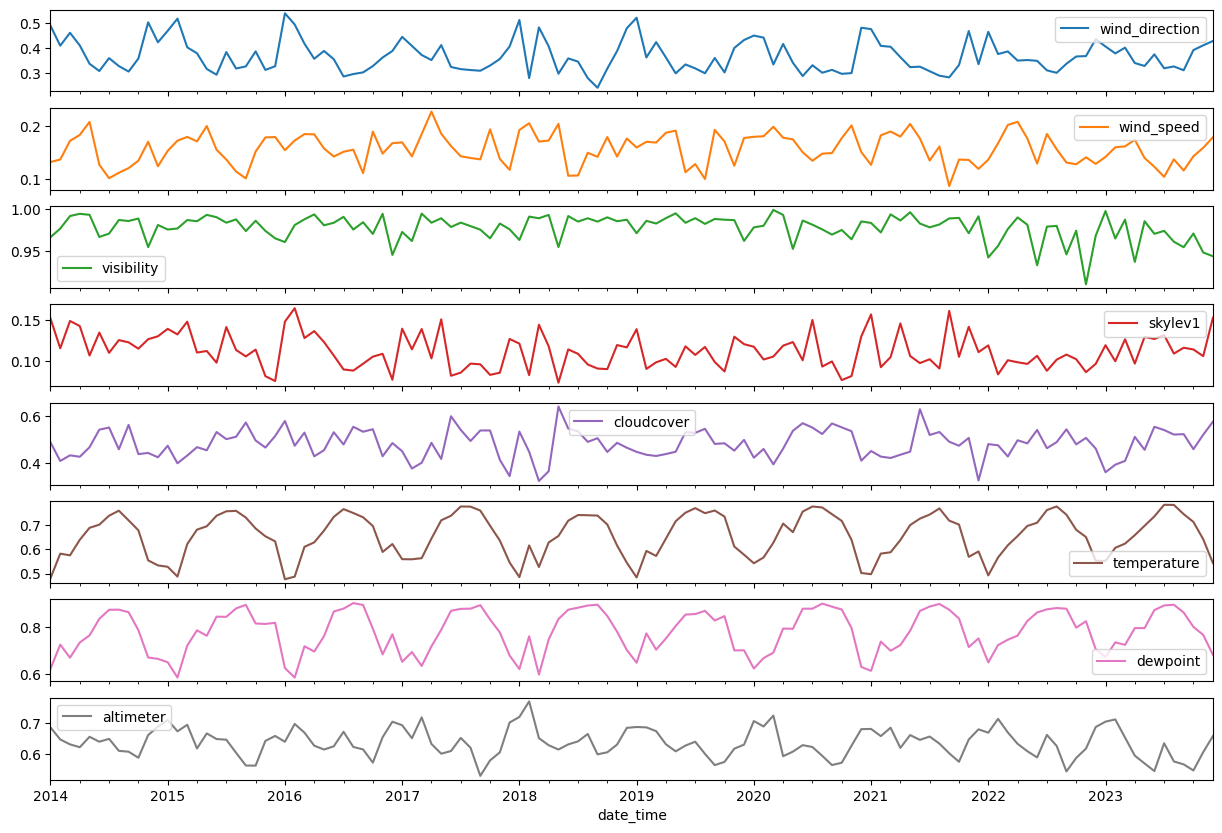

In [ ]:
daily_data = metar_data.resample('M').mean()

# Plotting trends over time
daily_data[continuous_columns].plot(subplots=True, figsize=(15, 10))
plt.show()

#### **Correlation analysis**

                wind_direction  wind_speed  visibility   skylev1  cloudcover  \
wind_direction        1.000000    0.131409   -0.044208  0.064965   -0.033850   
wind_speed            0.131409    1.000000   -0.029377 -0.140213    0.187943   
visibility           -0.044208   -0.029377    1.000000  0.102756   -0.222358   
skylev1               0.064965   -0.140213    0.102756  1.000000   -0.099698   
cloudcover           -0.033850    0.187943   -0.222358 -0.099698    1.000000   
temperature          -0.232680    0.220034    0.117549 -0.145929    0.189028   
dewpoint             -0.264628   -0.064115   -0.065632 -0.212146    0.277028   
altimeter            -0.094702    0.116291    0.073572  0.009748   -0.124430   

                temperature  dewpoint  altimeter  
wind_direction    -0.232680 -0.264628  -0.094702  
wind_speed         0.220034 -0.064115   0.116291  
visibility         0.117549 -0.065632   0.073572  
skylev1           -0.145929 -0.212146   0.009748  
cloudcover         0.189

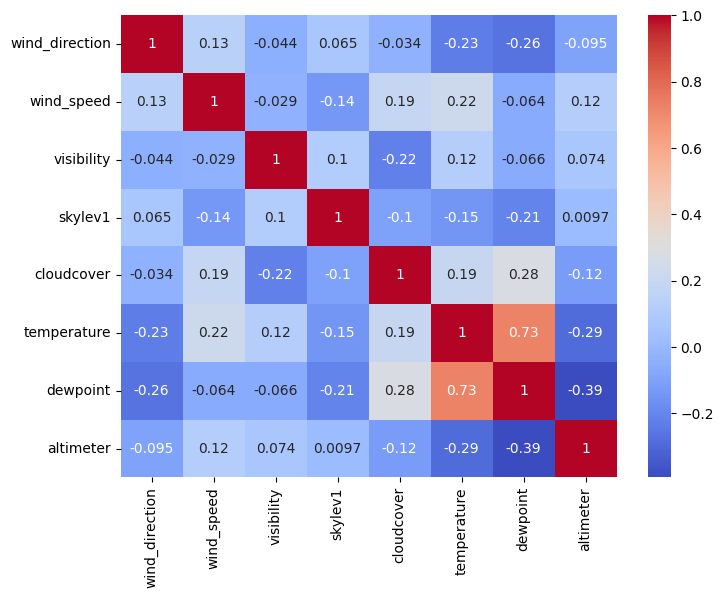

In [ ]:
# Correlation matrix
correlation_matrix = metar_data[continuous_columns].corr()
print(correlation_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

                            wind_direction_rolling_avg  \
wind_direction_rolling_avg                    1.000000   
wind_speed_rolling_avg                       -0.093534   
cloudcover_rolling_avg                       -0.130763   
visibility_rolling_avg                       -0.048546   
skylev1_rolling_avg                           0.293319   
temperature_rolling_avg                      -0.469874   
dewpoint_rolling_avg                         -0.436110   
altimeter_rolling_avg                        -0.169710   

                            wind_speed_rolling_avg  cloudcover_rolling_avg  \
wind_direction_rolling_avg               -0.093534               -0.130763   
wind_speed_rolling_avg                    1.000000                0.149265   
cloudcover_rolling_avg                    0.149265                1.000000   
visibility_rolling_avg                   -0.021517               -0.383372   
skylev1_rolling_avg                      -0.262455               -0.203655   
temperatu

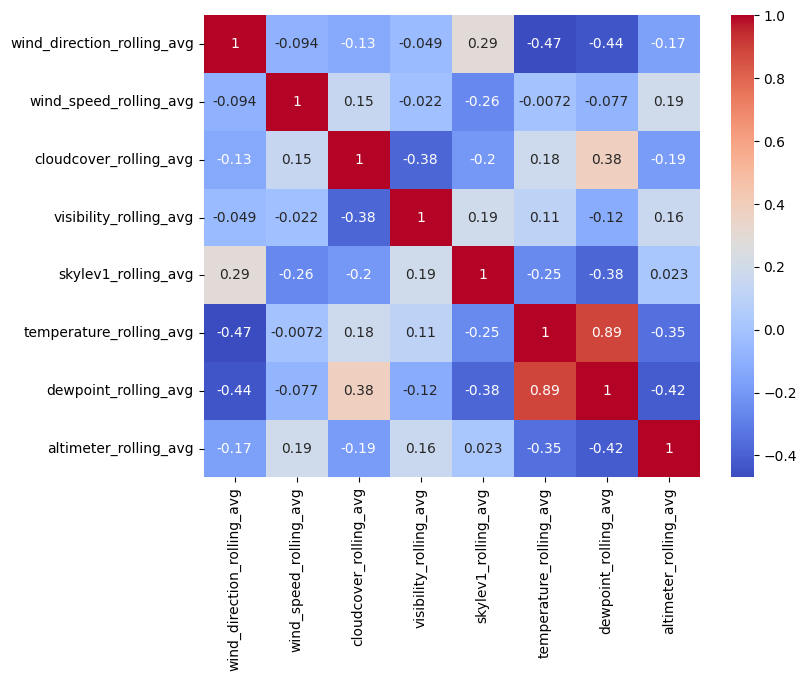

In [ ]:
# Correlation matrix with rolling avg
correlation_matrix = metar_data[['wind_direction_rolling_avg', 'wind_speed_rolling_avg', 'cloudcover_rolling_avg', 'visibility_rolling_avg', 'skylev1_rolling_avg', 'temperature_rolling_avg', 'dewpoint_rolling_avg', 'altimeter_rolling_avg']].corr()
print(correlation_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

We can see from this heatmap that the highest temperature across the hour of the day and month of the year seems to be around 1600 hours and August respectively

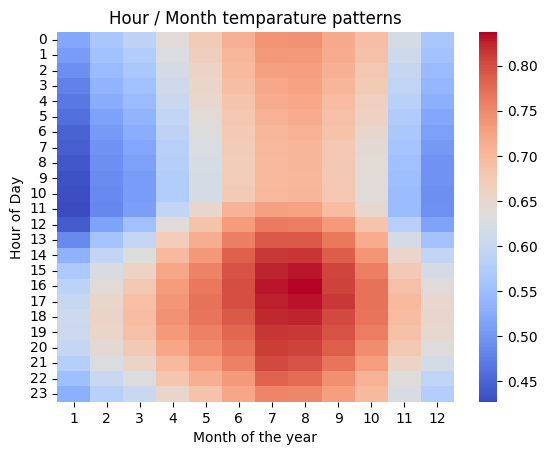

In [ ]:
# Pivot table to aggregate temperature by hour and day
pivot_hourly = metar_data.pivot_table(values='temperature', index='hour', columns='month', aggfunc='mean')

# Heatmap of hourly temperatures across days of the week
sns.heatmap(pivot_hourly, cmap='coolwarm')
plt.title('Hour / Month temparature patterns')
plt.xlabel('Month of the year')
plt.ylabel('Hour of Day')
plt.show()

#### **Outlier analysis**

1. For windspeed, September 10th 2017 is an outlier. This is consistent with the weather report here that reports a Hurricane in Miami, Florida - https://www.weather.gov/mfl/hurricaneirma#:~:text=On%20Sunday%20morning%2C%20September%2010,3%20with%20115%20mph%20winds.

2. For temperature, the anamoly seems to be the date 22nd Jan 2020 which is consistent with the weather report here - https://www.cbsnews.com/miami/news/cold-snap-coming-to-south-florida-feeling-the-30s-this-weekend/.

In [ ]:
# Calculate Q1 (10th percentile), Q3 (90th percentile), and IQR for wind_speed
Q1 = metar_data['wind_speed'].quantile(0.10)
Q3 = metar_data['wind_speed'].quantile(0.90)
IQR = Q3 - Q1

# Define outliers as points outside of Q1 - 1.5*IQR and Q3 + 1.5*IQR
outliers = metar_data[(metar_data['wind_speed'] < (Q1 - 1.5 * IQR)) | (metar_data['wind_speed'] > (Q3 + 1.5 * IQR))]

# Display the outlier data points
print(outliers['wind_speed'])

date_time
2017-09-10 03:53:00    0.720930
2017-09-10 05:53:00    0.697674
2017-09-10 06:53:00    0.697674
2017-09-10 08:53:00    0.906977
2017-09-10 09:53:00    0.720930
2017-09-10 10:53:00    1.000000
2017-09-10 11:53:00    0.790698
2017-09-10 12:53:00    1.000000
2023-05-25 16:53:00    0.697674
Name: wind_speed, dtype: float64


In [ ]:
# Calculate Q1 (10th percentile), Q3 (90th percentile), and IQR for temperature
Q1 = metar_data['temperature'].quantile(0.10)
Q3 = metar_data['temperature'].quantile(0.90)
IQR = Q3 - Q1

# Define outliers as points outside of Q1 - 1.5*IQR and Q3 + 1.5*IQR
outliers = metar_data[(metar_data['temperature'] < (Q1 - 1.5 * IQR)) | (metar_data['temperature'] > (Q3 + 1.5 * IQR))]

# Display the outlier data points
print(outliers['temperature'])

date_time
2020-01-22 10:53:00    0.030303
2020-01-22 11:53:00    0.000000
2020-01-22 12:53:00    0.030303
Name: temperature, dtype: float64


In [ ]:
metar_data.columns

Index(['wind_direction', 'wind_speed', 'visibility', 'current_wx1',
       'current_wx2', 'current_wx3', 'skyc1', 'skylev1', 'skyc2', 'skyc3',
       'skyc4', 'cloudcover', 'temperature', 'dewpoint', 'altimeter',
       'current_wx1_symbol', 'current_wx2_symbol', 'current_wx3_symbol',
       'remarks', 'month', 'day_of_week', 'hour', 'wind_direction_rolling_avg',
       'wind_speed_rolling_avg', 'visibility_rolling_avg',
       'skylev1_rolling_avg', 'cloudcover_rolling_avg',
       'temperature_rolling_avg', 'dewpoint_rolling_avg',
       'altimeter_rolling_avg'],
      dtype='object')

#### **Baseline model for prediction**

In [ ]:
metar_data.head()

,wind_direction,wind_speed,visibility,current_wx1,current_wx2,current_wx3,skyc1,skylev1,skyc2,skyc3,...,day_of_week,hour,wind_direction_rolling_avg,wind_speed_rolling_avg,visibility_rolling_avg,skylev1_rolling_avg,cloudcover_rolling_avg,temperature_rolling_avg,dewpoint_rolling_avg,altimeter_rolling_avg
date_time,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:53:00,0.111111,0.209302,1.0,None,None,None,OVC,0.072254,None,None,...,2,0,0.111111,0.209302,1.0,0.072254,0.8,0.575758,0.722222,0.769231
2014-01-01 01:53:00,0.111111,0.209302,1.0,None,None,None,OVC,0.066474,None,None,...,2,1,0.111111,0.209302,1.0,0.069364,0.8,0.575758,0.722222,0.769231
2014-01-01 02:53:00,0.138889,0.209302,1.0,-RA,None,None,OVC,0.072254,None,None,...,2,2,0.120370,0.209302,1.0,0.070328,0.8,0.575758,0.722222,0.774359
2014-01-01 03:53:00,0.194444,0.232558,1.0,None,None,None,OVC,0.080925,None,None,...,2,3,0.138889,0.215116,1.0,0.072977,0.8,0.575758,0.715278,0.773077
2014-01-01 04:53:00,0.194444,0.232558,1.0,None,None,None,OVC,0.080925,None,None,...,2,4,0.150000,0.218605,1.0,0.074566,0.8,0.581818,0.716667,0.769231


In [ ]:
# Continuous target variables
continuous_targets = ['wind_direction', 'wind_speed', 'cloudcover', 'skylev1', 'visibility', 'temperature', 'dewpoint', 'altimeter']

# Categorical target variables
categorical_targets = ['current_wx1', 'current_wx2', 'current_wx3', 'skyc1', 'skyc2', 'skyc3', 'skyc4']

In [ ]:
# Split the dataset
train_data = metar_data['2014-01-01':'2022-12-31']
test_data = metar_data['2023-01-01':'2023-12-31']

# Initialize dictionaries to store the actual and predicted values
actuals = {}
predictions = {}

# Calculate baseline predictions for continuous variables
for target in continuous_targets:
    # Calculate the hourly mean for the training data
    hourly_means = train_data.groupby([train_data.index.month, train_data.index.day, train_data.index.hour])[target].mean()

    # Map these means to the corresponding hours in the test data
    predictions[target] = test_data.index.map(lambda x: hourly_means.get((x.month, x.day, x.hour)))
    actuals[target] = test_data[target]

# Calculate baseline predictions for categorical variables
for target in categorical_targets:
    # Calculate the hourly mode for the training data
    hourly_modes = train_data.groupby([train_data.index.month, train_data.index.day, train_data.index.hour])[target].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

    # Map these modes to the corresponding hours in the test data
    predictions[target] = test_data.index.map(lambda x: hourly_modes.get((x.month, x.day, x.hour)))
    actuals[target] = test_data[target]

# Calculate RMSE for continuous variables and accuracy for categorical variables
rmse_scores = {target: np.sqrt(mean_squared_error(actuals[target], predictions[target])) for target in continuous_targets}
accuracy_scores = {target: accuracy_score(actuals[target], predictions[target].astype(str), normalize=True) for target in categorical_targets if not actuals[target].isnull().all()}

rmse_scores, accuracy_scores


<ipython-input-299-361de4a9ec84>:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = metar_data['2014-01-01':'2022-12-31']
<ipython-input-299-361de4a9ec84>:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = metar_data['2023-01-01':'2023-12-31']


({'wind_direction': 0.2938907499789095,
  'wind_speed': 0.0894847045977014,
  'cloudcover': 0.22770980085907322,
  'skylev1': 0.13031463610251878,
  'visibility': 0.14608898909700113,
  'temperature': 0.07858874054164601,
  'dewpoint': 0.0862575677915898,
  'altimeter': 0.07652776680520028},
 {'current_wx1': 0.888614625115705,
  'current_wx2': 0.9728478864547979,
  'current_wx3': 1.0,
  'skyc1': 0.5129075388254654,
  'skyc2': 0.35853131749460043,
  'skyc3': 0.5945695772909596,
  'skyc4': 0.8862491000719942})

#### **Model with XGBRegressor and XGBClassifier**

| Metric          | Baseline Model RMSE | XGBRegressor RMSE |
|-----------------|-------------------|----------------------------|
| wind_direction  | 0.2939            |  0.1820                          |
| wind_speed      | 0.0895            |  0.0455                          |
| cloudcover      | 0.2277            |  0.0113                          |
| skylev1         | 0.1303            |  0.0854                          |
| visibility      | 0.1461            |  0.0533                          |
| temperature     | 0.0786            |  0.0339                          |
| dewpoint        | 0.0863            |  0.0308                          |
| altimeter       | 0.0765            |  0.0209                          |

| Metric          | Baseline Model Accuracy | XGBClassifier Accuracy |
|-----------------|-------------------|----------------------------|
| current_wx1     | 0.8886            |  0.9152                          |
| current_wx2     | 0.9728            |  0.9936                          |
| current_wx3     | 1.0000            |  1.0000                          |
| skyc1           | 0.5129            |  0.7641                          |
| skyc2           | 0.3585            |  0.7716                          |
| skyc3           | 0.5946            |  0.8798                          |
| skyc4           | 0.8862            |  0.9439                          |


In [434]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBRegressor, XGBClassifier
import numpy as np
import pandas as pd

In [446]:
class METARModel:
    def __init__(self, target, data, is_categorical=False):
        self.target = target
        self.data = data
        self.is_categorical = is_categorical
        self.model = None
        self.label_encoder = None  # Only used for categorical targets
        self.encoded_features = None
        self.feature_importances = None

        # Define categorical columns for one-hot encoding, excluding the target if it's categorical
        self.categorical_columns = [col for col in ['current_wx1', 'current_wx2', 'current_wx3', 'skyc1', 'skyc2', 'skyc3', 'skyc4', 'month', 'day_of_week', 'hour']
                                    if col != target]

        self.continuous_columns = [col for col in ['wind_direction', 'wind_speed', 'cloudcover', 'skylev1', 'visibility', 'temperature', 'dewpoint', 'altimeter', 'wind_direction_rolling_avg', 'wind_speed_rolling_avg', 'visibility_rolling_avg', 'skylev1_rolling_avg', 'cloudcover_rolling_avg', 'temperature_rolling_avg', 'dewpoint_rolling_avg', 'altimeter_rolling_avg']
                                   if col != target]

        self._prepare_data()

    def _prepare_data(self):
        # Split the dataset
        train_data = self.data['2014-01-01':'2022-12-31']
        test_data = self.data['2023-01-01':'2023-12-31']

        X_train = train_data.drop([self.target], axis=1)
        y_train = train_data[self.target]
        X_test = test_data.drop([self.target], axis=1)
        y_test = test_data[self.target]

        if self.is_categorical:
            self.label_encoder = LabelEncoder()
            y_train = self.label_encoder.fit_transform(y_train)
            y_test = self.label_encoder.transform(y_test)

        # Define a transformer for one-hot encoding of categorical variables
        self.categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        # Apply transformations only to the specified categorical columns
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('cat', self.categorical_transformer, self.categorical_columns)
            ],
            remainder='passthrough'  # Keep other columns untouched
        )

        # Adjust the model to use XGBClassifier or XGBRegressor based on is_categorical
        if self.is_categorical:
            self.model = Pipeline(steps=[
                ('preprocessor', self.preprocessor),
                ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
            ])
        else:
            self.model = Pipeline(steps=[
                ('preprocessor', self.preprocessor),
                ('regressor', XGBRegressor())
            ])

        # Fit the model
        self.model.fit(X_train, y_train)

        # Predict
        y_pred = self.model.predict(X_test)
        if self.is_categorical:
            y_pred = self.label_encoder.inverse_transform(y_pred)
            # Evaluate using accuracy
            self.accuracy = accuracy_score(y_test, y_pred)
        else:
            # Calculate RMSE for continuous targets
            self.rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Extract feature names and importances
        self._extract_feature_importance(X_train)

    def _extract_feature_importance(self, X_train):
        try:
            encoded_features = self.model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=self.categorical_columns)
        except AttributeError:  # Fallback for older versions of scikit-learn
            encoded_features = self.model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(input_features=self.categorical_columns)

        non_categorical_features = [col for col in X_train.columns if col not in self.categorical_columns]
        all_features = list(encoded_features) + non_categorical_features

        if self.is_categorical:
            self.feature_importances = self.model.named_steps['classifier'].feature_importances_
        else:
            self.feature_importances = self.model.named_steps['regressor'].feature_importances_

        # Create a DataFrame for visualization
        self.importances_df = pd.DataFrame({
            'Feature': all_features,
            'Importance': self.feature_importances
        }).sort_values(by='Importance', ascending=False)

    def get_feature_importance(self):
        return self.importances_df

    def get_evaluation_metric(self):
        if self.is_categorical:
            return self.accuracy
        else:
            return self.rmse

    def predict_for_datetime(self, date_str, hour):
        """
        Predicts the target variable for a specific date and hour.

        Parameters:
        - date_str: A string representing the date, in the format 'YYYY-MM-DD'.
        - hour: An integer representing the hour of the day (0-23).

        Returns:
        - The predicted value for the target variable at the specified date and hour.
        """
        # Create a DataFrame with one row for the input features
        input_data = pd.DataFrame(index=[0])

        # Convert 'date_str' and 'hour' to datetime to extract 'month' and 'day_of_week'
        date = pd.to_datetime(date_str)
        input_data['month'] = [date.month]
        input_data['day_of_week'] = [date.dayofweek]
        input_data['hour'] = [hour]

        # Convert 'month', 'day_of_week', and 'hour' to string to align with training data preprocessing
        input_data['month'] = input_data['month'].astype(str)
        input_data['day_of_week'] = input_data['day_of_week'].astype(str)
        input_data['hour'] = input_data['hour'].astype(str)

        # Add placeholders for other features
        for feature in self.continuous_columns + self.categorical_columns:
            if feature not in ['month', 'day_of_week', 'hour']:
                # Assuming categorical features are objects and continuous features are float64
                if feature in ['current_wx1', 'current_wx2', 'current_wx3', 'skyc1', 'skyc2', 'skyc3', 'skyc4']:
                    input_data[feature] = ['']  # Use empty string for categorical placeholders
                else:
                    input_data[feature] = [0.0]  # Use 0.0 for continuous placeholders

        # # Ensure input_data matches the training data structure
        # prepared_input = self.preprocessor.transform(input_data)

        # Predict using the trained model
        pred = self.model.predict(input_data)

        # Decode the prediction if the target is categorical
        if self.is_categorical:
            pred = self.label_encoder.inverse_transform(pred.astype(int))

        return pred[0]  # Return the prediction for the single input instance


In [474]:
model_data = metar_data[['wind_direction', 'wind_speed', 'visibility', 'current_wx1',
       'current_wx2', 'current_wx3', 'skyc1', 'skylev1', 'skyc2', 'skyc3',
       'skyc4', 'cloudcover', 'temperature', 'dewpoint', 'altimeter', 'month', 'day_of_week', 'hour', 'wind_direction_rolling_avg',
       'wind_speed_rolling_avg', 'visibility_rolling_avg',
       'skylev1_rolling_avg', 'cloudcover_rolling_avg',
       'temperature_rolling_avg', 'dewpoint_rolling_avg',
       'altimeter_rolling_avg']]

In [465]:
model_temperature = METARModel(target='temperature', data=model_data, is_categorical=False)
print("RMSE for Temperature:", model_temperature.get_evaluation_metric())
print("Feature Importance for Temperature:\n", model_temperature.get_feature_importance().head(10))

<ipython-input-446-8aaf40cd1926>:22: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = self.data['2014-01-01':'2022-12-31']
<ipython-input-446-8aaf40cd1926>:23: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = self.data['2023-01-01':'2023-12-31']


RMSE for Temperature: 0.03391384521990475
Feature Importance for Temperature:
                      Feature  Importance
106  temperature_rolling_avg    0.223616
87                   hour_17    0.051124
85                   hour_15    0.048529
86                   hour_16    0.046725
88                   hour_18    0.045741
89                   hour_19    0.040807
80                   hour_10    0.037876
84                   hour_14    0.037547
90                   hour_20    0.037031
78                    hour_8    0.032990


In [466]:
model_wind_speed = METARModel(target='wind_speed', data=model_data, is_categorical=False)
print("RMSE for Wind Speed:", model_wind_speed.get_evaluation_metric())
print("Feature Importance for Wind Speed:\n", model_wind_speed.get_feature_importance().head(10))

<ipython-input-446-8aaf40cd1926>:22: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = self.data['2014-01-01':'2022-12-31']
<ipython-input-446-8aaf40cd1926>:23: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = self.data['2023-01-01':'2023-12-31']


RMSE for Wind Speed: 0.04557074209832012
Feature Importance for Wind Speed:
                     Feature  Importance
94           wind_direction    0.144652
102  wind_speed_rolling_avg    0.075373
30                skyc1_FEW    0.052714
32               skyc1_None    0.051418
87                  hour_17    0.045340
98              temperature    0.040574
88                  hour_18    0.036015
89                  hour_19    0.032945
90                  hour_20    0.029431
86                  hour_16    0.028152


In [467]:
model_wind_direction = METARModel(target='wind_direction', data=model_data, is_categorical=False)
print("RMSE for Wind Direction:", model_wind_direction.get_evaluation_metric())
print("Feature Importance for Wind Direction:\n", model_wind_direction.get_feature_importance().head(10))

<ipython-input-446-8aaf40cd1926>:22: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = self.data['2014-01-01':'2022-12-31']
<ipython-input-446-8aaf40cd1926>:23: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = self.data['2023-01-01':'2023-12-31']


RMSE for Wind Direction: 0.1820144766543913
Feature Importance for Wind Direction:
                         Feature  Importance
94                   wind_speed    0.153630
101  wind_direction_rolling_avg    0.153555
98                  temperature    0.058461
70                       hour_0    0.038557
102      wind_speed_rolling_avg    0.023208
93                      hour_23    0.021387
108       altimeter_rolling_avg    0.019460
107        dewpoint_rolling_avg    0.013897
24             current_wx2_None    0.013869
72                       hour_2    0.013778


In [468]:
model_cloudcover = METARModel(target='cloudcover', data=model_data, is_categorical=False)
print("RMSE for Cloudcover:", model_cloudcover.get_evaluation_metric())
print("Feature Importance for Cloudcover:\n", model_cloudcover.get_feature_importance().head(10))

<ipython-input-446-8aaf40cd1926>:22: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = self.data['2014-01-01':'2022-12-31']
<ipython-input-446-8aaf40cd1926>:23: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = self.data['2023-01-01':'2023-12-31']


RMSE for Cloudcover: 0.011341023433911135
Feature Importance for Cloudcover:
        Feature  Importance
38  skyc2_None    0.452596
29   skyc1_CLR    0.181864
44   skyc3_OVC    0.078783
43  skyc3_None    0.061449
30   skyc1_FEW    0.041674
34   skyc1_SCT    0.038739
37   skyc2_FEW    0.038079
40   skyc2_SCT    0.029339
41   skyc3_BKN    0.019573
49   skyc4_OVC    0.016276


{'wind_direction': 0.2938907499789095,
  'wind_speed': 0.0894847045977014,
  'cloudcover': 0.22770980085907322,
  'skylev1': 0.13031463610251878,
  'visibility': 0.14608898909700113,
  'temperature': 0.07858874054164601,
  'dewpoint': 0.0862575677915898,
  'altimeter': 0.07652776680520028}

In [469]:
model_skylev1 = METARModel(target='skylev1', data=model_data, is_categorical=False)
print("RMSE for Skylev1:", model_skylev1.get_evaluation_metric())
print("Feature Importance for Skylev1:\n", model_skylev1.get_feature_importance().head(10))

<ipython-input-446-8aaf40cd1926>:22: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = self.data['2014-01-01':'2022-12-31']
<ipython-input-446-8aaf40cd1926>:23: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = self.data['2023-01-01':'2023-12-31']


RMSE for Skylev1: 0.08545269480676106
Feature Importance for Skylev1:
                     Feature  Importance
38               skyc2_None    0.136375
97               cloudcover    0.113541
104     skylev1_rolling_avg    0.055875
30                skyc1_FEW    0.039483
11         current_wx1_None    0.032082
107    dewpoint_rolling_avg    0.028358
43               skyc3_None    0.025841
95               wind_speed    0.025534
105  cloudcover_rolling_avg    0.022764
85                  hour_15    0.021960


In [470]:
model_visibility = METARModel(target='visibility', data=model_data, is_categorical=False)
print("RMSE for Visibility:", model_visibility.get_evaluation_metric())
print("Feature Importance for Visibility:\n", model_visibility.get_feature_importance().head(10))

<ipython-input-446-8aaf40cd1926>:22: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = self.data['2014-01-01':'2022-12-31']
<ipython-input-446-8aaf40cd1926>:23: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = self.data['2023-01-01':'2023-12-31']


RMSE for Visibility: 0.053326383846539
Feature Importance for Visibility:
               Feature  Importance
24   current_wx2_None    0.449781
8      current_wx1_FG    0.215628
6      current_wx1_BR    0.107418
17    current_wx2_-RA    0.067953
2   current_wx1_+TSRA    0.023227
11   current_wx1_None    0.019738
15   current_wx1_VCTS    0.012244
1     current_wx1_+RA    0.009667
13     current_wx1_TS    0.009150
10     current_wx1_HZ    0.005381


In [471]:
model_dewpoint = METARModel(target='dewpoint', data=model_data, is_categorical=False)
print("RMSE for Dewpoint:", model_dewpoint.get_evaluation_metric())
print("Feature Importance for Dewpoint:\n", model_dewpoint.get_feature_importance().head(10))

<ipython-input-446-8aaf40cd1926>:22: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = self.data['2014-01-01':'2022-12-31']
<ipython-input-446-8aaf40cd1926>:23: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = self.data['2023-01-01':'2023-12-31']


RMSE for Dewpoint: 0.030870431928191167
Feature Importance for Dewpoint:
                         Feature  Importance
107        dewpoint_rolling_avg    0.680973
101  wind_direction_rolling_avg    0.026661
99                  temperature    0.019752
96                   visibility    0.015455
11             current_wx1_None    0.015119
97                      skylev1    0.014851
31                    skyc1_NSC    0.013645
95                   wind_speed    0.010562
98                   cloudcover    0.010454
94               wind_direction    0.009563


In [472]:
model_altimeter = METARModel(target='altimeter', data=model_data, is_categorical=False)
print("RMSE for Altimeter:", model_altimeter.get_evaluation_metric())
print("Feature Importance for Altimeter:\n", model_altimeter.get_feature_importance().head(10))

<ipython-input-446-8aaf40cd1926>:22: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = self.data['2014-01-01':'2022-12-31']
<ipython-input-446-8aaf40cd1926>:23: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = self.data['2023-01-01':'2023-12-31']


RMSE for Altimeter: 0.020946007702205952
Feature Importance for Altimeter:
                    Feature  Importance
108  altimeter_rolling_avg    0.329338
72                  hour_2    0.040904
85                 hour_15    0.037212
32              skyc1_None    0.035833
91                 hour_21    0.035590
84                 hour_14    0.033014
83                 hour_13    0.031776
73                  hour_3    0.030339
90                 hour_20    0.030065
78                  hour_8    0.029289


In [476]:
model_current_wx1 = METARModel(target='current_wx1', data=model_data, is_categorical=True)
print("RMSE for Current WX1:", model_current_wx1.get_evaluation_metric())
print("Feature Importance for Current WX1:\n", model_current_wx1.get_feature_importance().head(10))

<ipython-input-446-8aaf40cd1926>:22: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = self.data['2014-01-01':'2022-12-31']
<ipython-input-446-8aaf40cd1926>:23: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = self.data['2023-01-01':'2023-12-31']


RMSE for Current WX1: 0.0
Feature Importance for Current WX1:
              Feature  Importance
5     current_wx2_FU    0.113205
1    current_wx2_-RA    0.081107
80        visibility    0.071272
8   current_wx2_None    0.063697
82        cloudcover    0.060217
27        skyc3_None    0.057311
32        skyc4_None    0.044125
25         skyc3_BKN    0.026451
3     current_wx2_BR    0.026408
9     current_wx2_RA    0.024383


In [493]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['current_wx1', 'current_wx2','current_wx3','skyc1','skyc2','skyc3','skyc4','month','day_of_week','hour']

continuous_columns = ['wind_direction','wind_speed','cloudcover','skylev1','visibility','temperature','dewpoint','altimeter','wind_direction_rolling_avg','wind_speed_rolling_avg','visibility_rolling_avg','skylev1_rolling_avg','cloudcover_rolling_avg','temperature_rolling_avg','dewpoint_rolling_avg','altimeter_rolling_avg']

In [497]:
columns_to_predict = ['current_wx1', 'current_wx2','current_wx3','skyc1','skyc2','skyc3','skyc4']

for metric in columns_to_predict:

  model_data = metar_data[continuous_columns + categorical_columns]

  # Splitting the dataset
  train_data = model_data['2014-01-01':'2022-12-31']
  test_data = model_data['2023-01-01':'2023-12-31']

  if metric == 'current_wx2':
    test_data = model_data['2023-01-01':'2023-09-28']

  X_train = train_data.drop([metric], axis=1)
  y_train = train_data[metric]
  X_test = test_data.drop([metric], axis=1)
  y_test = test_data[metric]
  # Encode the target variable since XGBClassifier requires numerical encoding for categorical targets
  label_encoder = LabelEncoder()
  y_train_encoded = label_encoder.fit_transform(y_train)
  y_test_encoded = label_encoder.transform(y_test)

  # Define a transformer for one-hot encoding of categorical variables
  categorical_transformer = OneHotEncoder(handle_unknown='ignore')

  # Apply transformations only to the specified categorical columns
  preprocessor = ColumnTransformer(
      transformers=[
          ('cat', categorical_transformer, [item for item in categorical_columns if item != metric])
      ],
      remainder='passthrough'  # Keep other columns untouched
  )

  # Adjusting the model to use XGBClassifier
  model_current_wx1 = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
  ])

  # Fit the model using the encoded target
  model_current_wx1.fit(X_train, y_train_encoded)

  # Predict on the test set
  y_pred_encoded = model_current_wx1.predict(X_test)

  # Decode the predictions back to original labels
  y_pred = label_encoder.inverse_transform(y_pred_encoded)

  # Evaluate the model, for example, using accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print(f'Accuracy for predicting {metric}: {accuracy}')

  # First, get the feature names after one-hot encoding
  # The named_transformers_ attribute allows us to access the specific steps of our ColumnTransformer
  # 'cat' is the name we gave to our categorical transformer step
  encoded_features = model_current_wx1.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=[item for item in categorical_columns if item != metric])

  # Non-categorical features are left untouched, so we just append them after the encoded features
  non_categorical_features = [col for col in X_train.columns if col not in [item for item in categorical_columns if item != metric]]
  all_features = list(encoded_features) + non_categorical_features

  # Now, extract feature importances from the model
  feature_importances = model_current_wx1.named_steps['classifier'].feature_importances_

  # Create a DataFrame for easier visualization
  importances_df = pd.DataFrame({
      'Feature': all_features,
      'Importance': feature_importances
  })

  # Sort the DataFrame to see the most important features at the top
  importances_df = importances_df.sort_values(by='Importance', ascending=False)

  # Display the top 10 most important features
  print(importances_df.head(10))

<ipython-input-497-86ea71d281d8>:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = model_data['2014-01-01':'2022-12-31']
<ipython-input-497-86ea71d281d8>:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = model_data['2023-01-01':'2023-12-31']


Accuracy for predicting current_wx1: 0.9152524940861874
             Feature  Importance
5     current_wx2_FU    0.113205
1    current_wx2_-RA    0.081107
82        visibility    0.071272
8   current_wx2_None    0.063697
80        cloudcover    0.060217
27        skyc3_None    0.057311
32        skyc4_None    0.044125
25         skyc3_BKN    0.026451
3     current_wx2_BR    0.026408
9     current_wx2_RA    0.024383


<ipython-input-497-86ea71d281d8>:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = model_data['2014-01-01':'2022-12-31']
<ipython-input-497-86ea71d281d8>:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = model_data['2023-01-01':'2023-12-31']
<ipython-input-497-86ea71d281d8>:12: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = model_data['2023-01-01':'2023-09-28']


Accuracy for predicting current_wx2: 0.9936595451412819
             Feature  Importance
88        visibility    0.183812
6     current_wx1_BR    0.179666
8     current_wx1_FG    0.146062
11  current_wx1_None    0.082633
51          month_11    0.037756
15  current_wx1_VCTS    0.036009
89       temperature    0.019049
16    current_wx3_BR    0.013216
86        cloudcover    0.012489
44           month_4    0.012433


<ipython-input-497-86ea71d281d8>:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = model_data['2014-01-01':'2022-12-31']
<ipython-input-497-86ea71d281d8>:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = model_data['2023-01-01':'2023-12-31']


Accuracy for predicting current_wx3: 1.0
                    Feature  Importance
25           current_wx2_RA    0.351278
96               visibility    0.140130
16          current_wx2_+RA    0.136953
17          current_wx2_-RA    0.110669
15         current_wx1_VCTS    0.082003
101  wind_speed_rolling_avg    0.045120
103     skylev1_rolling_avg    0.020248
106    dewpoint_rolling_avg    0.018901
92           wind_direction    0.016295
95                  skylev1    0.014302


<ipython-input-497-86ea71d281d8>:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = model_data['2014-01-01':'2022-12-31']
<ipython-input-497-86ea71d281d8>:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = model_data['2023-01-01':'2023-12-31']


Accuracy for predicting skyc1: 0.7641674380335287
             Feature  Importance
29         skyc2_FEW    0.274018
88        cloudcover    0.192038
30        skyc2_None    0.159054
32         skyc2_SCT    0.065198
8     current_wx1_FG    0.052672
28         skyc2_BKN    0.031208
11  current_wx1_None    0.015608
35        skyc3_None    0.012061
87        wind_speed    0.010412
91       temperature    0.009645


<ipython-input-497-86ea71d281d8>:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = model_data['2014-01-01':'2022-12-31']
<ipython-input-497-86ea71d281d8>:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = model_data['2023-01-01':'2023-12-31']


Accuracy for predicting skyc2: 0.7716754088244369
       Feature  Importance
91  cloudcover    0.189089
38  skyc3_None    0.160315
30   skyc1_FEW    0.131945
40   skyc3_SCT    0.082353
33   skyc1_OVC    0.074902
28   skyc1_BKN    0.061960
37   skyc3_FEW    0.038758
36   skyc3_BKN    0.038340
34   skyc1_SCT    0.029160
39   skyc3_OVC    0.019279


<ipython-input-497-86ea71d281d8>:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = model_data['2014-01-01':'2022-12-31']
<ipython-input-497-86ea71d281d8>:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = model_data['2023-01-01':'2023-12-31']


Accuracy for predicting skyc3: 0.8798724673454695
             Feature  Importance
38        skyc2_None    0.223189
91        cloudcover    0.165113
40         skyc2_SCT    0.125098
43        skyc4_None    0.103172
39         skyc2_OVC    0.097472
37         skyc2_FEW    0.095762
36         skyc2_BKN    0.051838
11  current_wx1_None    0.020773
41         skyc4_BKN    0.013583
44         skyc4_OVC    0.008421


<ipython-input-497-86ea71d281d8>:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = model_data['2014-01-01':'2022-12-31']
<ipython-input-497-86ea71d281d8>:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = model_data['2023-01-01':'2023-12-31']


Accuracy for predicting skyc4: 0.9439473413555487
             Feature  Importance
43        skyc3_None    0.334605
41         skyc3_BKN    0.222181
91        cloudcover    0.107828
45         skyc3_SCT    0.084156
44         skyc3_OVC    0.062639
11  current_wx1_None    0.036069
28         skyc1_BKN    0.007489
42         skyc3_FEW    0.006247
37         skyc2_FEW    0.003945
6     current_wx1_BR    0.003500
